In [3]:
import sys, os
hpath = '/rds/general/user/cb2714/home/wwa/'
if os.path.exists("/home/cb2714/wwa/wwa.py"): hpath = '/home/cb2714/wwa/'
sys.path.append(hpath)
from wwa import *

In [4]:
rnm = "socal-baja"
sf = gpd.read_file("sf_socal-baja/").to_crs(epsg = 4326)

mapproj = cartopy.crs.PlateCarree()
xn, xx, yn, yx = [-121,-116,32,35]   # extent for figures
states = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50.to_geodataframe().clip((xn,yn,xx,yx))
la = [-118.24, 34.05]

# January FWI

In [40]:
da = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/cali-wildfires/era5_FWI_1940-2025.nc").FWI.sel(time = "2025-01-08")
rm = regionmask.defined_regions.natural_earth_v5_0_0.land_50.mask(da.longitude, da.latitude)
da = da.where(rm == 0)

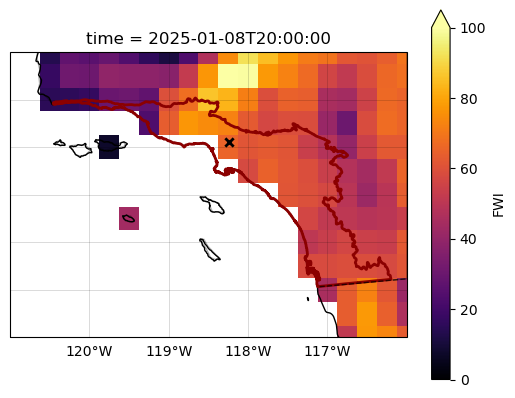

In [49]:
fig = da.plot(vmin = 0, vmax = 100, cmap = "inferno", subplot_kws = {"projection" : mapproj, "extent" : (xn,xx,yn,yx)})
ax = fig.axes
ax.gridlines(crs = mapproj, linewidth = 0.5, color = 'black', draw_labels = ["bottom"], alpha = 0.2)
states.boundary.plot(ax = ax, color = "k", alpha = 0.3, lw = 1)
ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
ax.coastlines()

sf.boundary.plot(ax = ax, color = "darkred", lw = 2)
ax.scatter(*la, marker = "x", color = "k", lw = 2)

# 2023-2024 precipitation vs previous years

In [13]:
days = pd.date_range(start = "2020-07-01", end = "2021-07-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b") for i in range(366) if (days[i].day) == 15]

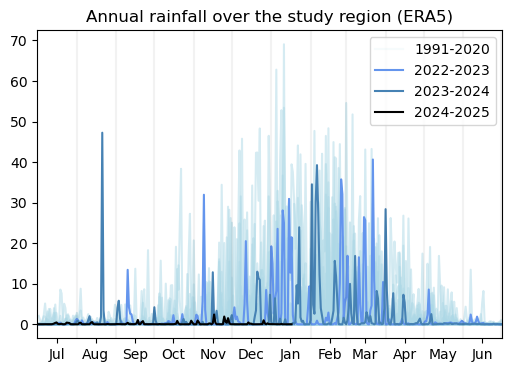

In [19]:
ts = xr.open_dataset("data/era5_pr_"+rnm+".nc").pr
ts = ts.assign_coords(offset_time = ("time", ts.time.shift(time = 181).data))

fig, ax = plt.subplots(ncols = 1, figsize = (6,4), dpi = 100, sharex = True, sharey = True)

for y in range(1991,2020):
    ts_y = ts.sel(time = ts.offset_time.dt.year == y)
    ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "lightblue", alpha = 0.5, label = "_years")

y = 1991; ts_y = ts.sel(time = ts.offset_time.dt.year == y); ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "lightblue", alpha = 0.1, label = "1991-2020")
y = 2022; ts_y = ts.sel(time = ts.offset_time.dt.year == y); ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "cornflowerblue", label = "2022-2023")
y = 2023; ts_y = ts.sel(time = ts.offset_time.dt.year == y); ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "steelblue", label = "2023-2024")
y = 2024; ts_y = ts.sel(time = ts.offset_time.dt.year == y); ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "k", label = "2024-2025")

ax.legend()
ax.set_xticks(labelticks)
ax.set_xticklabels(labels)
[ax.axvline(x, color = "k", alpha = 0.05) for x in range(366) if (days[x].day) == 1]
ax.set_title("Annual rainfall over the study region (ERA5)")
plt.margins(x = 0)

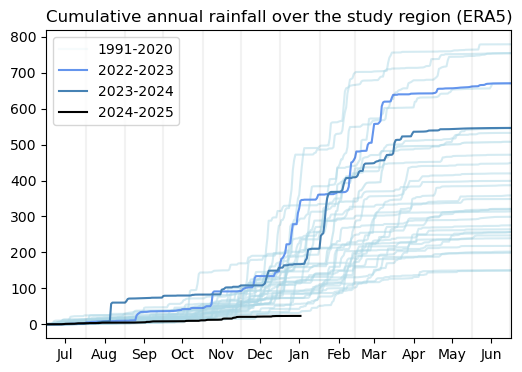

In [18]:
ts = xr.open_dataset("data/era5_pr_"+rnm+".nc").pr
ts = ts.assign_coords(offset_time = ("time", ts.time.shift(time = 181).data))

fig, ax = plt.subplots(ncols = 1, figsize = (6,4), dpi = 100, sharex = True, sharey = True)

for y in range(1991,2020):
    ts_y = ts.sel(time = ts.offset_time.dt.year == y).cumsum()
    ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "lightblue", alpha = 0.5, label = "_years")

y = 1991; ts_y = ts.sel(time = ts.offset_time.dt.year == y); ax.plot(ts_y.offset_time.dt.dayofyear, ts_y.cumsum(), color = "lightblue", alpha = 0.1, label = "1991-2020")
y = 2022; ts_y = ts.sel(time = ts.offset_time.dt.year == y); ax.plot(ts_y.offset_time.dt.dayofyear, ts_y.cumsum(), color = "cornflowerblue", label = "2022-2023")
y = 2023; ts_y = ts.sel(time = ts.offset_time.dt.year == y); ax.plot(ts_y.offset_time.dt.dayofyear, ts_y.cumsum(), color = "steelblue", label = "2023-2024")
y = 2024; ts_y = ts.sel(time = ts.offset_time.dt.year == y); ax.plot(ts_y.offset_time.dt.dayofyear, ts_y.cumsum(), color = "k", label = "2024-2025")

ax.legend()
ax.set_xticks(labelticks)
ax.set_xticklabels(labels)
[ax.axvline(x, color = "k", alpha = 0.05) for x in range(366) if (days[x].day) == 1]
ax.set_title("Cumulative annual rainfall over the study region (ERA5)")
plt.margins(x = 0)

# Change in drought end timing

# Synthesis

In [5]:
def synth_plot(df, ax = None, logged = False, split_uw = False):
    
    # set split_uw = True to plot the unweighted mean of obs and models on its own line
    if not ax: fig, ax = plt.subplots(dpi = 100)
    
    gcols = {"obs" : "blue", 
             "obs_synth" : "blue", 
             "models" : "red", 
             "model_synth" : "red",
             "synth" : "magenta"}
    
    # relabel obs as a single bar if only one dataset
    if "obs" in df.index and len(df.loc[["obs"]]) == 1:
        df = df.loc[df.index != "obs"]
        df.loc["obs_synth", "model"] = "ERA5"
    
    ylabels = df.model.to_list()
    
    ax.grid(axis = "x", which = "major", color = "k", alpha = 0.1)
    
    if logged:
        ax.set_xscale('log')
        ax.axvline(1, ls = "--", color = "k", zorder = -99)
    else:
        ax.axvline(0, ls = "--", color = "k", zorder = -99)
    
    for k in range(len(df)):

        r = df.iloc[k]
        ax.add_patch(Rectangle((r.lower,-k-0.3), r.upper - r.lower, 0.6, facecolor = gcols[r.name], alpha = 0.5 + 0.5*("synth" in r.name)))
        ax.plot(r.est, -k, color = "k", marker = "v")
        
        if not (split_uw and df.index[k] == "synth"): 
            ax.add_patch(Rectangle((r.l_wb,-k-0.3), r.u_wb - r.l_wb, 0.6, edgecolor = "k", facecolor = "none", lw = 1.5))
        else:
            k = k+1
            ax.add_patch(Rectangle((r.l_wb,-k-0.3), r.u_wb - r.l_wb, 0.6, edgecolor = "k", facecolor = "none", lw = 1.5))
            if logged:
                uw_mean = np.exp((np.log(df.loc["obs_synth", "est"]) + np.log(df.loc["model_synth", "est"])) / 2)
            else:
                uw_mean = (df.loc["obs_synth", "est"] + df.loc["model_synth", "est"]) / 2
            ax.plot(uw_mean, -k, color = "k", marker = "v")
            ylabels = ylabels + ["unweighted mean"]

    ax.set_yticks(range(0, -len(ylabels), -1))
    ax.set_yticklabels(ylabels)

In [6]:
# load data

varnm = "dc7-doy-wrapped"
synth = {x+"_"+y: pd.read_csv("synth/synth_"+varnm+"_"+x+"-"+y+".csv", index_col = "group") for x in ["dI", "PR"] for y in ["attr", "proj"]}

In [11]:
title_a = {"dc7-doy" : "Change in season end",
           "dc7-doy-wrapped" : "Change in season end",
           "spi-ond" : "Change in OND SPI",
           "fwi1x-rel" : "% change in FWI1X"}
dI_xlim = {"dc7-doy" : (-30,55), "dc7-doy-wrapped" : (-55,55), "spi-ond" : (-1.4, 1.4), "fwi1x-rel" : (-18,42)}
PR_xlim = {"dc7-doy" : (10**-1, 10**1.5), "dc7-doy-wrapped" : (10**-1, 10**1), "spi-ond" : (10**-1.2, 10**2.2), "fwi1x-rel" : (10**-1.2,10**1.2)}

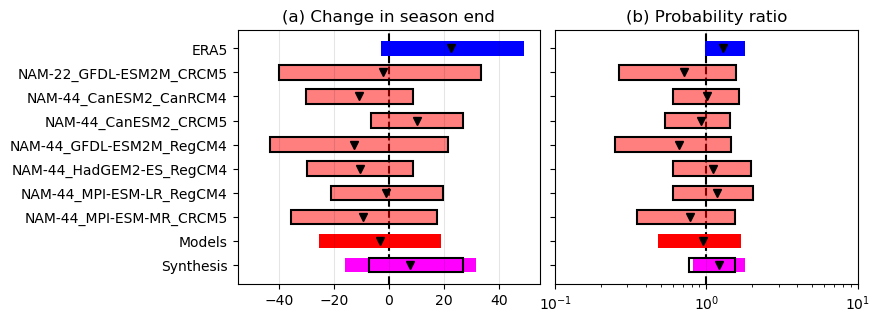

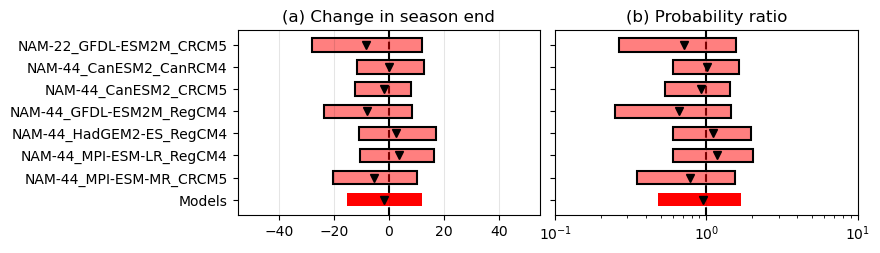

In [12]:
fig, axs = plt.subplots(ncols = 2, sharey = True, figsize = (8,len(synth["dI_attr"])*0.3))
plt.subplots_adjust(wspace = 0.05)

synth_plot(synth["dI_attr"], ax = axs[0], logged = False)
axs[0].set_title("(a) "+ title_a[varnm])
axs[0].set_xlim(*dI_xlim[varnm])

synth_plot(synth["PR_attr"], ax = axs[1], logged = True)
axs[1].set_title("(b) Probability ratio")
axs[1].set_xlim(*PR_xlim[varnm])

plt.savefig("fig/synth_"+varnm+"_attr.png")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

fig, axs = plt.subplots(ncols = 2, sharey = True, figsize = (8,len(synth["dI_proj"])*0.3))
plt.subplots_adjust(wspace = 0.05)

synth_plot(synth["dI_proj"], ax = axs[0], logged = False)
axs[0].set_title("(a) "+ title_a[varnm])
axs[0].set_xlim(*dI_xlim[varnm])

synth_plot(synth["PR_proj"], ax = axs[1], logged = True)
axs[1].set_title("(b) Probability ratio")
axs[1].set_xlim(*PR_xlim[varnm])

plt.savefig("fig/synth_"+varnm+"_proj.png")

In [15]:
df = pd.read_csv("ts/cordex_dc7-doy_NAM-44_MPI-ESM-MR_r1i1p1_CRCM5.csv", index_col = "year")

<AxesSubplot: xlabel='year'>

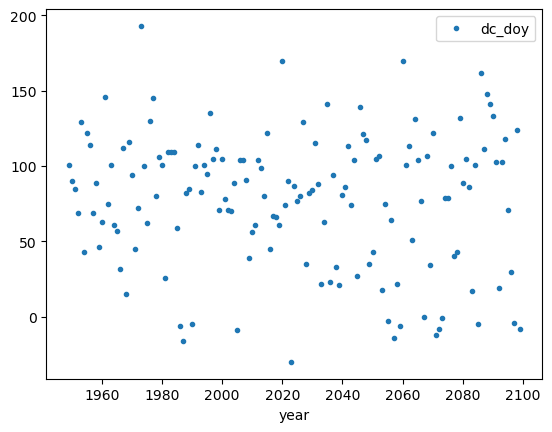

In [17]:
df.plot(marker = ".", ls = "")